# Using Logistic Regression for Intrusion Detection on the KDD-99 Dataset
*By Daniel Jones*

--- 

In this section of the report, a logistic regression model is implemented in Python using the sci-kit learn library [2]. Within this, the effectiveness of feature selection is determined, and penalisation introduced as a method of increasing the models performance. 

## Preliminaries

The notebook needs to be setup with the required libraries and dependencies loaded. The Python dependencies are located in [requirements.txt](../requirements.txt) in the root project directory. There are setup instructions in the [README](../README.md).

To run this notebook, either select "Kernel -> Restart & Run All" from the menu, or run each cell from top to bottom.

In [49]:
import matplotlib 
import numpy
import pandas
import seaborn

from sklearn import decomposition
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from statsmodels import api as sm

import warnings
warnings.filterwarnings('ignore')

random_state = numpy.random.RandomState(0)

%matplotlib inline

Load 10% of the KDD-99 dataset, containing a list of Transmission Control Protocol (TCP) connections. The code below uses the column names from `kddcup.names`. Though note that the final column, containing class labels, has been named `connection_labels`.

In [ ]:
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'connection_label']
connection_events = pandas.read_csv('../data/kddcup.data_10_percent.gz', names=columns)  # sourced from http://kdd.ics.uci.edu/ [1]

The `connection_label` feature describes the source of each connection: this is either an identifier of its attack-type, or `normal.`.

Since the task is to separate malicious behavour from normal network behaviour, the code below separates these labels from the rest of the dataset, then groups all malicious traffic under the label `bad.`:

In [189]:
connection_labels = connection_events.filter(['connection_label'], axis='columns')
connection_events = connection_events.drop(['connection_label'], axis='columns')

In [190]:
def generate_label(label):
    return 'normal.' if label == 'normal.' else 'bad.'

connection_labels['connection_label'] = connection_labels['connection_label'].apply(generate_label)

## Data Preparation

The code below performs 10-fold cross-validation, providing the array `train_test_splits`. It does this using the [model selection](http://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold) part of the scikit-learn library. The `StratifiedKFold` module ensures that class ratios are preserved within each split.

In [191]:
k_fold_splitter = model_selection.StratifiedKFold(n_splits=10,  random_state=random_state)
train_test_splits = k_fold_splitter.split(
    connection_events,  # data to be split
    connection_labels,  # target/class to split by
)
train_test_splits = list(train_test_splits)  # force evaluation of generator so we can interate over this muiltiple times

## Data Model

Here we consider potential enhancements to the standard logistic regression technique. In particular, we investigate the use of Principle Component Analysis (PCA) to rank and select features of the model. Further, we consider the applicability of adding a penalization term to the maximum likelihood estimation.

Before we apply the above mentioned techniques, the data must be cleaned and converted to a format compatible with a linear model.

In [197]:
# Find the categorical columns
connection_events.select_dtypes(include=[object]).describe()

,protocol_type,service,flag
count,494021,494021,494021
unique,3,66,11
top,icmp,ecr_i,SF
freq,283602,281400,378440


There are a couple of options when converting categorical features into numeric features. One potential option is to sequentially number each value. This has the downside of adding an implicit ordering between each value, i.e. that $0 > 1 > 2 > 3 > …$. None of `protocol_type`, `service`, or `flag` have a meaningful ordering between their values, so we should avoid this approach if possible.

A second approach is to use one-hot-encoding, which transforms each categorical feature with $n$ values into $n$ binary features. This does have the disadvantage of removing a constraint on the data: it is now possible for each datapoint to have multiple values for e.g.  the `service` column. Since we aren't doing too much data manipulation, this should not be an issue for us. The code below uses `pandas.get_dummies` to apply a one-hot-encoding onto the categorical columns found above:

In [198]:
connection_events = pandas.get_dummies(connection_events, columns=["protocol_type", "service", "flag"])

# Check the result of the transformation
connection_events.filter(regex='(flag|protocol_type|service).*', axis='columns').head()

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Normalize the mean and variance of the data; this is performed by sci-kit learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) which uses the z-score to perform the scaling:

In [199]:
standard_scaler = preprocessing.StandardScaler()

connection_events = pandas.DataFrame(
    standard_scaler.fit_transform(connection_events),
    columns=connection_events.columns,
    index=connection_events.index,
)

Convert the datapoint labels into 0's or 1's:

In [200]:
label_to_number = {'bad.': 1, 'normal.': 0}
number_to_label = {1: 'bad.',  0: 'normal.'}

connection_labels['connection_label'] = connection_labels['connection_label'].map(label_to_number)

#### Feature Selection

Selecting a subset of the KDD 99 datasets original features presents a number of advantages. When running intrusion detection systems within the internal network of an organisation, the system should be running and identifying threats in real-time. To do this, it needs to record, store and process the organisations traffic in a short time frame. Removing features known to be noisy and irrelevant should allow a higher percentage of network activity to be recorded, reduce the storage cost, and speed up the classification algorithm [5]. 

One potential approach for feature selection is to use the resulting vectors from Principle Component Analysis (PCA) to determine the importance of each of the original features. 

Principle Component Analysis (PCA) is a procedure which converts a set of potentially correlated predictor variables into a set of uncorrelated variables. It does this be decomposing the covariance matrix of the original dataset into a set of eigenvalues and eigenvectors:

$$ \text{Cov}(X) = U \Sigma U^T $$

where:
  - X is the original dataset, 
  - $\text{Cov}(x)$ is the covariance matrix of X, 
  - M is the number of features in the original dataset, 
  - $\Sigma$ is a diagonal matrix of the M eigenvalues, 
  - and U is a matrix of M eigenvectors in columns [8]


These principle components can then be used to discover the amount of covariance between numeric features or, most often, for dimensionality reduction. In this section we evaluate the use of PCA to identify important features, and reduce the dimensionality of the dataset. 

The code below uses scikit-learn's [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) module to find the principle components. it does this by computing the singular value decomposition (SVD) of it's covariance matrix, which is a standard approach:

In [201]:
pca = decomposition.PCA(
    svd_solver='full',  # force sci-kit learn to compute the exact PCA rather than an estimation
    random_state=random_state,
)

pca.fit(connection_events)

PCA(copy=True, iterated_power='auto', n_components=None,
  random_state=<mtrand.RandomState object at 0x7ff29e5066c0>,
  svd_solver='full', tol=0.0, whiten=False)

Once the principle components have been computed, it is important to consider:
  1. The individual impact of each principle component on the dataset.
  2. The impact on each feature of the KDD-99 on the principle components.
  
To do this we create the following two plots:

In [ ]:
shared_fig, (explained_variance_axes, feature_weighting_axes) = matplotlib.pyplot.subplots(ncols=2)
shared_fig.set_size_inches(16, 6)

# 1. The plot below considers how much of the original datasets variance is explained by each principle component [4]:
explained_variance = pandas.DataFrame(
    list(zip(
            pca.explained_variance_ratio_, 
            pca.explained_variance_ratio_.cumsum()
    )),
    columns=[
        'explained_variance',
        'cumulative_explained_variance',
    ]
)
seaborn.scatterplot(data=explained_variance, ax=explained_variance_axes)
_ = explained_variance_axes.set(
    title='Plot showing the fraction of variance \n explained by each component.',
    xlabel='Principle Component',
    ylabel='Fraction of Total Variance',
)

# 2. This plot  considers weightings of original features against each component from PCA [4]:
feature_identity_matrix = numpy.eye(connection_events.shape[1])
feature_weighting = numpy.abs(pca.inverse_transform(feature_identity_matrix))

seaborn.heatmap(
    feature_weighting,
    cbar=True,
    ax=feature_weighting_axes,
    cmap='hot',
    vmin=0,
    vmax=1,
)
_ = feature_weighting_axes.set(
    title='Heatmap showing the relative importance of each feature in the \n KDD-99 dataset (as determined by it\'s principle components).',
    xlabel='KDD-99 Feature Index',
    ylabel='Principle Component',
)

In [203]:
# How many principle components are required to explain 95% of the datasets variance?
explained_variance.query('cumulative_explained_variance > 0.95').iloc[0].name + 1  # increment since indices are 0-based

83

The first plot shows that the variance is equally distributed across each of the principle components. In fact, to explain 95% of the original datasets variance, 83 principle components are required. It is clear that using PCA for dimensionality reduction would provide minimal gains, and add an unnecessary level of indirection between the source data and our results.

The second plot shows the relative importance of each feature in the KDD-99 dataset as determined by PCA. It shows that the importance of each feature is equally distributed. Unfortunately, it will therefore be hard to reduce the number of dimensions without affecting the models accuracy. Any dimensionality reduction for increased speed will require a trade-off in model performance.

Therefore, the best results will be found by using the majority of the features in the original KDD-99 dataset.

#### Penalization

Plan:
  - Describe maximum likelihood estimation
  - potential issues with MLE
  - motivation for penalisation:
    - rare class problem 
    - l1 shown to be useful for feature selection
  - describe penalisation modfication of MLE
  - potential loss functions
  - choosing the regularisation parameter
    - what does sklearn do?
    
    
Since there is no closed-form solution, Maximum Likelihood Estimation (MLE) is often used to fit logistic regression models [3]. MLE aims to find the parameters, $\vec{\theta}$, of the model that maximise the likelihood of those parameters given the data,   $\ell(\vec{\theta}|X)$.

Multi-collinearity between features can cause high variances on the parameter estimates. We could decrease any multi-collinearity between features using PCA. However, we have found that PCA is not effective on this data set. One alternative is to add a penalization factor to the objective function used by MLE  [6]

$$M(\theta) = \ell(\theta|\boldsymbol{x}) - \lambda P(\theta)$$

where
  - $P(\theta)$ is the *penalisation function* which aims to value unrealistic values of parameters less,
  - and $\lambda$ is the *regularisation parameter* which controls the trade-off between the penalisation and likelihood functions.
  
Consider two potential penalty functions:
  - *Lasso (L1):* 
  $P(\vec{\theta}) = \sum_{j=1}^{p}{|\theta_j - 0|}$
  - *Ridge (L2):* 
  $P(\vec{\theta}) = \sum_{j=1}^{p}{(\theta_j - 0)^2}$
  
Here, both functions measure the distance from parameters to the origin. In "Penalized logistic regression with rare events" [7] it was found that the lasso penalty function provided more effective results when aiming to identify rare labels. This could be investigated for use in production environments, where malicious events are rare. In the case of the KDD-99 dataset, however, ridge regression may provide better results.

The code below uses sklearns [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) implementation with ridge penalisation. Every feature in the dataset has been used as a predictor variable (with the exception of the class labels). For each of the 10 train/test splits, this code trains the model and generates predictions from the test set. These predictions are recorded in `testing_predictions` for later analysis.

In [204]:
# WARNING! Slow code cell ahead.

predicted_label_sets = []

for training_indices, testing_indices in train_test_splits:
    training_data = connection_events.iloc[training_indices]
    training_labels = connection_labels.iloc[training_indices]

    logistic_regression = linear_model.LogisticRegression(penalty='l2')
    logistic_regression.fit(training_data, training_labels)
    
    testing_data = connection_events.iloc[testing_indices]
    predicted_labels = logistic_regression.predict(testing_data)
    
    predicted_label_sets.append(predicted_labels)

As a brief summary of the models performance, the code below computes a confusion matrix for each of the 10-folds. It then sums the confusion matrices element-wise to create a summary of the results:

In [205]:
testing_label_sets = [connection_labels.iloc[testing_indexes].connection_label for training_indexes, testing_indexes in train_test_splits]

In [206]:
confusion_matrixes = [
    metrics.confusion_matrix(testing_labels, predicted_labels)
    for testing_labels, predicted_labels
    in zip(testing_label_sets, predicted_label_sets)
]

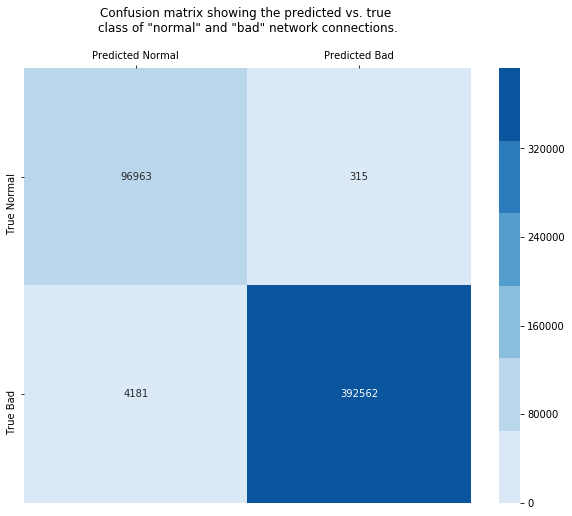

In [231]:
summary_confusion_matrix = sum(confusion_matrixes)
summary_confusion_matrix = pandas.DataFrame(
    data=summary_confusion_matrix, 
    index=['True Normal', 'True Bad'], 
    columns=['Predicted Normal', 'Predicted Bad'],
)

summary_confusion_figure, summary_confusion_axes = matplotlib.pyplot.subplots()
summary_confusion_figure.set_size_inches(10, 8)
summary_confusion_axes.set_title(
    'Confusion matrix showing the predicted vs. true \n'
    'class of "normal" and "bad" network connections.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
summary_confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = seaborn.heatmap(
    summary_confusion_matrix,
    annot=True,
    fmt="d",
    cmap=seaborn.color_palette("Blues"),
    vmin=0,
    ax=summary_confusion_axes,
)

The above confusion matrix will be input into the main report for further evaluation, and comparison with out other models.

###### References

[1]: Hettich, S. and Bay, S. D. (1999). The UCI KDD Archive [http://kdd.ics.uci.edu]. Irvine, CA: University of California, Department of Information and Computer Science.

[2]: Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

[3]: Practical Statistics for Data Science, 1st ed., by Peter Bruce and Andrew Bruce (O’Reilly Media, 2017).

[4]: Principal Component Analysis (PCA) for Feature Selection and some of its Pitfalls, http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/

[5]: Liu, Huan, and Lei Yu. "Toward integrating feature selection algorithms for classification and clustering." IEEE Transactions on knowledge and data engineering 17.4 (2005): 491-502. https://doi.org/10.1109/TKDE.2005.66

[6]: BST 764: Applied Statistical Modelling, https://web.as.uky.edu/statistics/users/pbreheny/764-F11/notes/8-30.pdf

[7]: Penalized logistic regression with rare events: Preliminary Results, p12 http://prema.mf.uni-lj.si/files/PREMAPreliminary_Lara_AS2015_f98.pdf.

[8]: Data Science Toolbox, Daniel Lawson, 05-LatentStructuresPCA_01.pdf.